# Calculate Job Power Schedules with ILP

This program is designed to take in n number of distinct power scheduling jobs and determine their ideal ordering in to minimize the peak amount of power demand above a provided resource curve. 
\
Becuase this it an ILP program, it will find the optimal solution to the problem, but will take greater than polynomial time to do so. 


In [1]:
import cplex
import json
import matplotlib.pyplot as plt
import numpy as np
import random

# Generate Jobs and Other Variables
We need to generate the jobs, decision variables and extract other information that will be necessary for the ILP to run

**Jobs** -> The power requiring tasks upon which this problem is built. Each job will have the following format:
\
\
&emsp;&emsp;**release** -> The minimum time that a specific job can begin by. A job can begin no earlier than the release time \
&emsp;&emsp;**deadline** -> The maximum time that a job must complete by. A job can end no later than the deadline time \
&emsp;&emsp;**duration** -> The length (in minutes) that a task will need to complete \
&emsp;&emsp;**height** -> The amount of consistent power that a task will require

In [2]:
# This is The list of job objects that will be scheduled
# They each have a release, deadline, duration and height
path = '../../Input_Data/job_data.json'
with open(path, 'r') as file:
    data = json.load(file)

start_time = 0
end_time = 1400
max_length = 700
batch_size = 50

# Randomly shuffle the jobs so that there is variation between trials
jobs_array = data['jobs']
random.shuffle(jobs_array)

jobs = []

# Iterate through the job objects and create an array of objects that fall within the specified time window
i = 0
curr_index = 0
while (i < batch_size):
    aj = jobs_array[curr_index]['release']
    dj = jobs_array[curr_index]['deadline']
    lj = jobs_array[curr_index]['length']

    # Check if the specific job lies within the correct window
    # The funky syntax is used to put the job id at the very front of the dictionary
    if aj >= start_time and dj <= end_time and lj <= max_length:
        job_id = {"job_id" : i}
        job_object = {**job_id, **jobs_array[curr_index]}
        jobs.append(job_object)
        
        i += 1
    
    curr_index += 1

**Intervals** -> The overall intervals list is composed of exactly J sublists, where J = the number of total jobs
\
\
&emsp;&emsp;- Each entry within a sublist is a two integer tuple representing a possible start and end execution time for the corresponding job \
&emsp;&emsp;- For example, the entry (3, 6) in the intervals[0] means that the first job can possibly execute between time steps 3 and 6 (where the start \
&emsp;&emsp;time is inclusive and the end time is exclusive)

In [3]:
intervals = [[] for _ in range(len(jobs))]
for i, job in enumerate(jobs):
    # Extract the necessary information from the job object
    release = job['release'] - start_time
    deadline = job['deadline'] - start_time
    duration = job['length']
    num = release

    # Add the execution intervals to the sublist
    while (num + duration <= deadline):
        intervals[i].append((num, num + duration))
        num += 1

**Time Steps** -> This is simply the number of time steps in the time period between the specified start and end time. Each time step equates to exactly one minute.

In [4]:
# Specify the number of time steps 
num_time_steps = end_time - start_time

**Resources** -> This is a list that keeps track of the amount of available resources at each time step
\
\
&emsp;&emsp;- The resource curve information will be gathered from the Data/ folder.

In [5]:
# Instantiate the resource curve

path = '../../Input_Data/solar_data.json'
with open(path, 'r') as file:
    data = json.load(file)

wind_energy = data['series'][1]['data']
solar_energy = data['series'][2]['data']
hydro_energy = data['series'][3]['data']

# Have 165 hours and you want minute by minute resolution. Therefore the total length of this list needs to be 165 * 60 in length
# The first 60 values of the list need to equal 0, the next need to equal 1. Therefore, i // 60
wind_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(wind_energy_7_days)):
    wind_energy_7_days[i] = wind_energy[ i // 60 ]['value']

solar_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(solar_energy_7_days)):
    solar_energy_7_days[i] = solar_energy[ i // 60 ]['value']

hydro_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(hydro_energy_7_days)):
    hydro_energy_7_days[i] = hydro_energy[ i // 60 ]['value']


total = []
for i in range(165 * 60):
    total_sum = wind_energy_7_days[i] + solar_energy_7_days[i] + hydro_energy_7_days[i]
    total.append(total_sum)

resources = total[start_time:end_time]


**Height** -> This is a list containing exactly J entries, where each entry contains that height of the corresponding job. The height of the jobs will be dependent on a scale factor. For now, we will scale the jobs based on the relationship between the max value of the resource curve and the max value of the naive job schedule
\
\
The naive job schedule, generated below, scehdules each job exactly at their respective start times. From this, we generate the scale factor. We want the peak to be 75% above the resource curve (for now)
\
\
&emsp;&emsp;- The height is another word for the amount of the given resource that a job will consistently require while it is running.
\
&emsp;&emsp;- Therefore, height[0] = 400 means that the first job requires 400 unites of the given resource
\


In [6]:
bad_heights = [0 for _ in range(num_time_steps)]
for job in jobs:
    aj = job['release'] - start_time
    hj = job['height']
    lj = job['length']

    for i in range(aj, aj + lj):
        bad_heights[i] += hj


scale_factor = (max(resources) * 2) / max(bad_heights)

In [7]:
# Iterate through the jobs and add their corresponding heights
height = [job['height'] * scale_factor for job in jobs]

# Decision Variables
**Decision variables** -> A key component of the ILP. They represent each distint execution interval for each job. They can assume any value in [0, 1]. 
\
\
&emsp;&emsp;- This code creates a list of decision variables with the form {'name': x_i_j, value: ?} where each name is a distinct time interval for a distinct job. 
\
&emsp;&emsp;- Specifically, this is saying that decision variable x_i_j is the ith possible interval for job j where the value is the actual interval of time steps. 
\
&emsp;&emsp;- This is stored here so we don't have to repeatedly query the intervals list
\
\
**Objective variable** -> Instantiate the variable that will be minimized during the problem's execution

In [8]:
decision_variables = []
for j, interval_set in enumerate(intervals):
    for i, interval in enumerate(interval_set):
        # Add the decision variable and it's corresponding interval to the list
        decision_variables.append({'name' : f'x_{i}_{j}', 'value': interval})

# Instantiate the objective variable
objective_variable = 'd'

# Create the ILP
Create an ILP problem with CPLEX. We have to specify the decision variables for the problem. And then we must specify their respective upper bounds and lower bounds.
\
\
Finally we have to set up the objective function. In this case, the objective function will be to minimize a variable named 'd'. Where d is initially set to the highest point the job schedule curve could possibly be, which is the total sum of the 'heights' list.

In [9]:
# Create the cplex problem
problem = cplex.Cplex()
problem.set_problem_type(cplex.Cplex.problem_type.LP)
problem.set_results_stream(None)

# Maximize objective
problem.objective.set_sense(problem.objective.sense.minimize)

# This retrieves the names of all of the decision variables 
names = [variable['name'] for variable in decision_variables] + [objective_variable]

# these are the other parameters needed to form the basis of the linear programming problem
obj = [0 for _ in range(len(decision_variables))] + [1]
lb = [0 for _ in range(len(decision_variables))] + [0]
ub = [1 for _ in range(len(decision_variables)) ] + [sum(height)]

# Establish the problem
types = [problem.variables.type.integer] * (len(decision_variables)) + [problem.variables.type.continuous]
problem.variables.add(obj=obj, lb=lb, ub=ub, types=types, names=names)

range(0, 3943)

# Constraints
This will generate the first set of constraints

This for loop adds the constraints that make it so that a job can run during only one interval. So for each job, aggregate all of the decision variables that correspond to each possible execution interval for that job. Then specify that they all of those decision variables can only add up to one  

In [10]:
curr_index = 0
for interval in intervals:
    # Aggregate all the decision variables that belong to one job
    variables = decision_variables[curr_index : curr_index + (len(interval))]
    variables = [v['name'] for v in variables]
    curr_index += len(interval)
    
    # The coefficient of each decision variable is one
    constraints = [1 for _ in range(len(variables))]

    # This is saying that the sum of each of the decision variabels can only equal one
    problem.linear_constraints.add(
        lin_expr=[ [ variables, constraints ] ],
        senses=['E'],
        rhs=[1]
    )

This generates the second set of constraints 
\
\
It aggregates all of the desicion variables that correspond to intervals that could possibly be running during that time step. /
It then aggregates the heights corresponding to the jobs that each decision variable represents. 
It multiplies those heights by the decision variables. However, the constrain ensures that the total sum is less than the max height d

In [11]:
for i in range(num_time_steps):
    use_variables = []
    use_height = []

    for variable in decision_variables:
        
        # Check the interval times of the corresponding variable
        # Then check if the current timestep falls within that interval
        job_interval_start, job_interval_end = variable['value'][0], variable['value'][1]

        # if i >= job_interval_start and i <= job_interval_end: #COME BACK TO THIS
        if job_interval_start <= i < job_interval_end:
            job_id = int(variable['name'].split('_')[-1])

            use_height.append(height[job_id])
            use_variables.append(variable['name'])

    # Add d to the decision variables 
    use_variables.append('d')
    use_height.append(-1)

    # Add the linear constraint to the problem
    problem.linear_constraints.add(
        lin_expr=[ [ use_variables, use_height ] ],
        senses=['L'],
        rhs=[resources[i]]
    )

# Solve the ILP problem

Use CPLEX to solve the formulated ILP problem and then use post processing to extract the intervals each job will run in.

In [12]:
problem.solve()

solution = problem.solution
print("Status:", solution.get_status_string())
print("Objective value:", solution.get_objective_value())

Status: integer optimal solution
Objective value: 4565.076725542382


This code does some post processing to generate a list that represents the aggregated heights of all the jobs when they execute in their chosen execution windows

In [13]:
final_heights = [0 for _ in range(num_time_steps)]
for name in names:
    val = solution.get_values(name)

    if val == 1 and name != 'd':
        job_id = int(name.split('_')[-1])
        interval_id = int(name.split('_')[1])
        interval = intervals[job_id][interval_id]
    
        for i in range(interval[0], interval[1]):
            final_heights[i] += height[job_id]

# Plot the Jobs

Use Matplotlib to plot the jobs on a curve

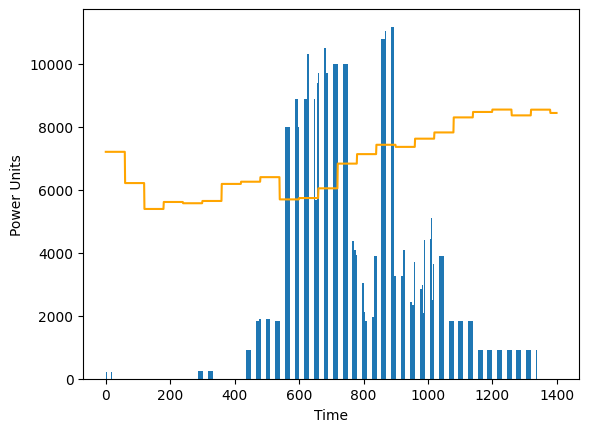

In [14]:
job_graph_xvalues = np.array([i for i in range(start_time, end_time)])
job_graph_yvalues = np.array(final_heights)

plt.bar(job_graph_xvalues, job_graph_yvalues, label="jobs", width=0.5)
plt.plot(job_graph_xvalues, resources, label='resources', color='orange')

plt.xlabel("Time")
plt.ylabel("Power Units")

plt.show()
